In [16]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [17]:
# %pip install -r ../requirements.txt

In [18]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib

In [19]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [20]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [ ]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2019',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon'] #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [22]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures,
    ft.AirQualityFeatures,
    ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    ft.GoogleTrendFeatures,
    ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    ft.PopulationFeatures,
    ft.SportsCompetitionFeatures,
    ft.TrafficFeatures
    ]

In [23]:
# Select the target columns to be predicted
target_colomns = ['nb_emmergencies']
# target_colomns = ['nb_vers_hospit']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [24]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [25]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [26]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14adfc880>),
                                ('pipelin...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14adff880>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14adff100>)],
                  verbose=True)

In [27]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [28]:
features_config_get = {}

In [ ]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'], #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard'],
    'axis': 'columns',
    'shift': range(1, 7, 1),
    'rolling_window': [14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': -3, #-3,
    'targets_rolling_window': 3, #3,
    'targets_history_shifts': range(7, 14, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr':0.65,
    'data_dir': root_dir / 'data',
    'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0],
    # 'target_bins': [0, 0.3, 0.7, 1.0],
    'replace_target': True,
    }

In [30]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-13 15:06:34,410: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-13 15:06:34,422: INFO: Initialisation des features
root 2024-11-13 15:06:34,425: INFO: Fetching data for hospitalfeatures at CHU Dijon
root 2024-11-13 15:06:34,662: INFO: Fetching data for airqualityfeatures at CHU Dijon
root 2024-11-13 15:06:34,852: INFO: Fetching data for epidemiologicalfeatures at CHU Dijon
root 2024-11-13 15:06:35,021: INFO: Fetching data for googletrendfeatures at CHU Dijon
root 2024-11-13 15:06:35,197: INFO: Fetching data for meteorologicalfeatures at CHU Dijon
root 2024-11-13 15:06:35,371: INFO: Fetching data for sociologicalfeatures at CHU Dijon
root 2024-11-13 15:06:35,607: INFO: Fetching data for populationfeatures at CHU Dijon
root 2024-11-13 15:06:35,768: INFO: Fetching data for sportscompetitionfeatures at CHU Dijon
root 2024-11-13 15:06:36,164: INFO: Fetching data for trafficfeatures at CHU Dijon
root 2024-11-13 15:06:36,551: INFO: Getting the dataset from 01-0

Dropped columns with zero variance: []
Column 'PM10_FR26010' is constant at 15.0 for 68.79% of the rows.
Column 'PM10_FR26094' is constant at 19.0 for 88.06% of the rows.
Column 'PM25_FR26094' is constant at 6.8 for 87.58% of the rows.
Column 'NO2_FR26010' is constant at 6.9 for 68.62% of the rows.
Column 'NO2_FR26094' is constant at 7.0 for 87.61% of the rows.
Dropped columns with zero variance: ['PM10_FR26010', 'PM10_FR26094', 'PM25_FR26094', 'NO2_FR26010', 'NO2_FR26094']


root 2024-11-13 15:06:36,995: INFO: Getting data for epidemiologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:06:37,013: INFO: Augmentation des features...
root 2024-11-13 15:06:37,074: INFO: Getting data for googletrendfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:06:37,125: INFO: Augmentation des features...
root 2024-11-13 15:06:37,186: INFO: Getting data for meteorologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:06:37,202: INFO: Augmentation des features...


Dropped columns with zero variance: []
Column 'trend_diarrhée' is constant at 0.0 for 95.85% of the rows.
Column 'trend_vomissements' is constant at 0.0 for 99.64% of the rows.
Column 'trend_toux' is constant at 0.0 for 92.29% of the rows.
Column 'trend_éruption cutanée' is constant at 0.0 for 99.77% of the rows.
Column 'trend_infection urinaire' is constant at 0.0 for 98.08% of the rows.
Column 'trend_médecin' is constant at 0.0 for 81.11% of the rows.
Column 'trend_médicament' is constant at 0.0 for 98.31% of the rows.
Column 'trend_fièvre' is constant at 0.0 for 99.32% of the rows.
Column 'trend_grippe' is constant at 0.0 for 85.54% of the rows.
Column 'trend_rhume' is constant at 0.0 for 98.45% of the rows.
Column 'trend_angine' is constant at 0.0 for 98.13% of the rows.
Column 'trend_otite' is constant at 0.0 for 98.68% of the rows.
Column 'trend_allergie' is constant at 0.0 for 96.17% of the rows.
Column 'trend_asthme' is constant at 0.0 for 99.45% of the rows.
Column 'trend_stre

root 2024-11-13 15:06:37,356: INFO: Getting data for sociologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:06:37,374: INFO: Augmentation des features...
root 2024-11-13 15:06:37,445: INFO: Getting data for populationfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:06:37,486: INFO: Augmentation des features...


Dropped columns with zero variance: []
Dropped columns with zero variance: []


root 2024-11-13 15:06:37,775: INFO: Getting data for sportscompetitionfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:06:37,781: INFO: Augmentation des features...
root 2024-11-13 15:06:37,793: INFO: Getting data for trafficfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:06:37,799: INFO: Augmentation des features...
root 2024-11-13 15:06:37,874: WARNING: Not shifting the target is not allowed as some features might not be available for today's date,                                            
as well as applying a positive shift as it would results in predicting the past                                            
Will use a default shift of -1 if targets_shift == 0 or of -targets_shift if targets_shift < 0
root 2024-11-13 15:06:37,875: INFO: Creating the target columns as nb_emmergencies_CHU Dijon shifted by -1
root 2024-11-13 15:06:37,877: INFO: Creating target history columns...
root 2024-1

Dropped columns with zero variance: []
Column 'nb_accidents' is constant at 0.0 for 76.37% of the rows.
Dropped columns with zero variance: ['nb_accidents']
Dropped 0 constant columns from both sets: []
X shape: (1167, 749), y shape: (1167, 1)
            target_nb_emmergencies_CHU Dijon%%J+1
date                                             
2019-01-01                                  198.0
2019-01-02                                  186.0
2019-01-03                                  186.0
2019-01-04                                  204.0
2019-01-05                                  182.0
...                                           ...
2022-03-08                                  186.0
2022-03-09                                  195.0
2022-03-10                                  222.0
2022-03-11                                  213.0
2022-03-12                                  174.0

[1167 rows x 1 columns]
[ColumnTransformer] .... (1 of 4) Processing pipeline-1, total=   0.0s
[ColumnTra

In [31]:
df = arsTabularDataset.y_train

# Identifie les colonnes contenant des NaN
cols_with_nan = df.columns[df.isna().any()].tolist()
print("Colonnes contenant des NaN:", cols_with_nan)

# Affiche la liste des index des lignes contenant des NaN pour chaque colonne
nan_indices = {col: df[df[col].isna()].index.tolist() for col in cols_with_nan}
nan_indices

Colonnes contenant des NaN: []


{}

In [32]:
df

,target_nb_emmergencies_CHU Dijon%%J+1
date,
2019-01-01,198.0
2019-01-02,186.0
2019-01-03,186.0
2019-01-04,204.0
2019-01-05,182.0
...,...
2022-03-08,186.0
2022-03-09,195.0
2022-03-10,222.0


In [33]:
# arsTabularDataset.data['target_nb_emmergencies_CHU Dijon%%J+1%%mean_1J'].astype('category')

In [34]:
# df['target_nb_emmergencies_CHU Dijon%%J+1%%mean_1J'].astype(int)
# df['target_nb_emmergencies_CHU Dijon%%J+1%%mean_1J'].astype('category')

In [35]:
df

,target_nb_emmergencies_CHU Dijon%%J+1
date,
2019-01-01,198.0
2019-01-02,186.0
2019-01-03,186.0
2019-01-04,204.0
2019-01-05,182.0
...,...
2022-03-08,186.0
2022-03-09,195.0
2022-03-10,222.0


In [ ]:
# print(arsTabularDataset.data.columns.to_list())
# Define the model parameters
model_params = {
    
    'early_stopping_rounds': 10,
    # 'eval_set': [(arsTabularDataset.enc_X_val, arsTabularDataset.y_val)], # TODO: to be set in the experiment's run method
    'verbosity': 0,
    'n_estimators': 10000,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    # 'multi_strategy': 'one_output_per_tree',
    # 'multi_strategy': 'multi_output_tree' 
}

In [ ]:
metrics = ['w_rmse', 'pw_rmse', 'rmse', 'mae', 'mse'] # first one is used for evaluation and everywhere a sinlge metric is used, the rest are used for testing
# metrics = ['']

In [ ]:
# Create the model
model = get_model(model_type='xgboost', name='XGBoost', device='cpu', task_type='regression', test_metrics=metrics, params=model_params)

In [39]:
# Create the experiment
ars_experiment = BaseExperiment(logger=logger, dataset=arsTabularDataset, model=model)

In [40]:
# Set the model fitting config
grid_params = {
    'max_depth': [3, 5, 7, 9, 11],
}

In [41]:
fit_params = {
    'verbose': 0,
}

In [42]:
model_config={"optimization": "grid", "grid_params": grid_params, "fit_params": fit_params}

2024/11/13 15:06:40 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/11/13 15:06:40 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
root 2024-11-13 15:06:40,433: INFO: Running the experiment...
root 2024-11-13 15:06:40,482: INFO: => Recherche des 89 features les + pertinentes
root 2024-11-13 15:06:40,485: INFO:    - Grande variance
root 2024-11-13 15:06:40,513: INFO:    - Coefficient de corrélation de Pearson
root 2024-11-13 15:06:41,517: INFO:    - Coefficient de corrélation de Kendall
root 2024-11-13 15:06:42,967: INFO:    - Coefficient de corrélation de Spearman
root 2024-11-13 15:06:43,564: INFO:    - Random forests
root 2024-11-13 15:06:54,531: INFO:    - Régression linéaire
root 2024-11-13 15:06:54,751: INFO: [333 335 345 347 357 367 369 371 379 381 383 384 395 405 407 415 419 

Fitting estimator with 794 features.


Fitting estimator with 694 features.


Fitting estimator with 594 features.


Fitting estimator with 494 features.


Fitting estimator with 394 features.


Fitting estimator with 294 features.


Fitting estimator with 194 features.


Fitting estimator with 94 features.


root 2024-11-13 15:07:11,530: INFO: => Exploration des features
root 2024-11-13 15:07:11,798: INFO: ['w_rmse', 'pw_rmse', 'rmse', 'mae', 'mse'] With target_nb_emmergencies_CHU Dijon%%J+1%%mean_14J%%J-1 number 0: inf -> 28.69530664035151
('mae', 15.047252665480523)	('mse', 363.9780234127331)	('rmse', 19.078208076565605)	('w_rmse', 28.69530664035151)	('pw_rmse', 31.719284196817412)
root 2024-11-13 15:07:12,132: INFO: ['w_rmse', 'pw_rmse', 'rmse', 'mae', 'mse'] With nb_emmergencies_CHU Dijon number 1: 28.69530664035151 -> 28.4912047837935
('mae', 15.49353165299925)	('mse', 378.1652157949201)	('rmse', 19.44647052282033)	('w_rmse', 28.4912047837935)	('pw_rmse', 31.103718410309895)
root 2024-11-13 15:07:13,312: INFO: ['w_rmse', 'pw_rmse', 'rmse', 'mae', 'mse'] With nb_emmergencies%%J-5_CHU Dijon number 4: 28.4912047837935 -> 28.46178378088328
('mae', 15.276870142270441)	('mse', 372.28664335447417)	('rmse', 19.294730973881812)	('w_rmse', 28.46178378088328)	('pw_rmse', 30.333928497430602)
root

Dropped columns with zero variance: []
Column 'PM10_FR26010' is constant at 15.0 for 68.79% of the rows.
Column 'PM10_FR26094' is constant at 19.0 for 88.06% of the rows.
Column 'PM25_FR26094' is constant at 6.8 for 87.58% of the rows.
Column 'NO2_FR26010' is constant at 6.9 for 68.62% of the rows.
Column 'NO2_FR26094' is constant at 7.0 for 87.61% of the rows.
Dropped columns with zero variance: ['PM10_FR26010', 'PM10_FR26094', 'PM25_FR26094', 'NO2_FR26010', 'NO2_FR26094']


root 2024-11-13 15:07:45,775: INFO: Augmentation des features...
root 2024-11-13 15:07:45,875: INFO: Getting data for googletrendfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:07:45,934: INFO: Augmentation des features...


Dropped columns with zero variance: []
Column 'trend_diarrhée' is constant at 0.0 for 95.85% of the rows.
Column 'trend_vomissements' is constant at 0.0 for 99.64% of the rows.
Column 'trend_toux' is constant at 0.0 for 92.29% of the rows.
Column 'trend_éruption cutanée' is constant at 0.0 for 99.77% of the rows.
Column 'trend_infection urinaire' is constant at 0.0 for 98.08% of the rows.
Column 'trend_médecin' is constant at 0.0 for 81.11% of the rows.
Column 'trend_médicament' is constant at 0.0 for 98.31% of the rows.
Column 'trend_fièvre' is constant at 0.0 for 99.32% of the rows.
Column 'trend_grippe' is constant at 0.0 for 85.54% of the rows.
Column 'trend_rhume' is constant at 0.0 for 98.45% of the rows.
Column 'trend_angine' is constant at 0.0 for 98.13% of the rows.
Column 'trend_otite' is constant at 0.0 for 98.68% of the rows.
Column 'trend_allergie' is constant at 0.0 for 96.17% of the rows.
Column 'trend_asthme' is constant at 0.0 for 99.45% of the rows.
Column 'trend_stre

root 2024-11-13 15:07:45,999: INFO: Getting data for meteorologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:07:46,024: INFO: Augmentation des features...
root 2024-11-13 15:07:46,097: INFO: Getting data for sociologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:07:46,110: INFO: Augmentation des features...


Column 'meteo_snow' is constant at 0.0 for 97.61% of the rows.
Dropped columns with zero variance: ['meteo_snow']
Dropped columns with zero variance: []


root 2024-11-13 15:07:46,254: INFO: Getting data for populationfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:07:46,303: INFO: Augmentation des features...


Dropped columns with zero variance: []


root 2024-11-13 15:07:46,713: INFO: Getting data for sportscompetitionfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:07:46,721: INFO: Augmentation des features...
root 2024-11-13 15:07:46,747: INFO: Getting data for trafficfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-13 15:07:46,757: INFO: Augmentation des features...
root 2024-11-13 15:07:46,896: WARNING: Not shifting the target is not allowed as some features might not be available for today's date,                                            
as well as applying a positive shift as it would results in predicting the past                                            
Will use a default shift of -1 if targets_shift == 0 or of -targets_shift if targets_shift < 0
root 2024-11-13 15:07:46,897: INFO: Creating the target columns as nb_emmergencies_CHU Dijon shifted by -1
root 2024-11-13 15:07:46,900: INFO: Creating target history columns...
root 2024-1

Dropped columns with zero variance: []
Column 'nb_accidents' is constant at 0.0 for 76.37% of the rows.
Dropped columns with zero variance: ['nb_accidents']


root 2024-11-13 15:07:46,964: WARNING: Target target_nb_emmergencies_CHU Dijon%%J+1 not in features_names, adding it to continue
root 2024-11-13 15:07:46,968: INFO: Calculating train/val/test sets and encodings...


Dropped 0 constant columns from both sets: []
X shape: (1167, 3), y shape: (1167, 1)
            target_nb_emmergencies_CHU Dijon%%J+1
date                                             
2019-01-01                                  198.0
2019-01-02                                  186.0
2019-01-03                                  186.0
2019-01-04                                  204.0
2019-01-05                                  182.0
...                                           ...
2022-03-08                                  186.0
2022-03-09                                  195.0
2022-03-10                                  222.0
2022-03-11                                  213.0
2022-03-12                                  174.0

[1167 rows x 1 columns]
[ColumnTransformer] .... (1 of 3) Processing pipeline-1, total=   0.0s
[ColumnTransformer] .... (2 of 3) Processing pipeline-3, total=   0.0s
[ColumnTransformer] .... (3 of 3) Processing pipeline-4, total=   0.1s
            pipeline-1__sta

root 2024-11-13 15:08:04,091: INFO: Model fitted.
root 2024-11-13 15:08:16,254: INFO: Scoring the model...
root 2024-11-13 15:08:16,282: INFO: Testing the model...
root 2024-11-13 15:08:16,298: INFO: Plotting the results...
matplotlib.legend 2024-11-13 15:08:16,339: WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024/11/13 15:08:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run run_15 at: http://127.0.0.1:8080/#/experiments/424186559360271593/runs/b26ec55115ac41878f27012f07c28394.
2024/11/13 15:08:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/424186559360271593.
2024/11/13 15:08:16 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/11/13 15:08:17 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


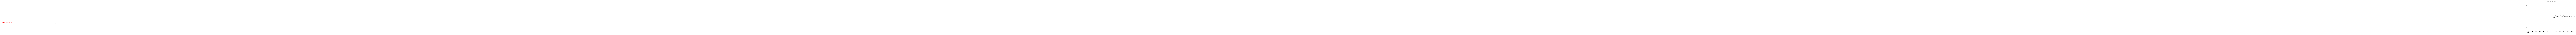

In [43]:
# Run the experiment
ars_experiment.run(dataset_config=dataset_config, model_config=model_config, find_best_features=True, int_pred=True, balance_target=False)